In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import pickle
import lightgbm as lgb

In [2]:
df = pd.read_csv('train.csv')

In [3]:
X_code = df.drop(['target'], axis=1).values
y = df['target'].values
X_code_train, X_code_val, y_train, y_val = train_test_split(X_code, y, test_size= 0.2, random_state=0, stratify=y)

X_train = X_code_train[:,1:].astype(np.float)
code_train = X_code_train[:,0]
X_val = X_code_val[:,1:].astype(np.float)
code_val = X_code_val[:,0]

In [4]:
neg_mask_train = y_train ==0
pos_mask_train = y_train == 1
neg_mask_val = y_val == 0
pos_mask_val = y_val == 1

In [20]:
pca = PCA()
sc = StandardScaler()
mm_pca = MinMaxScaler()

X_train_stan = sc.fit_transform(X_train)
trans_train_dum = pca.fit_transform(X_train_stan)
trans_train = mm_pca.fit_transform(trans_train_dum)

X_val_stan = sc.transform(X_val)
trans_val_dum = pca.transform(X_val_stan)
trans_val = mm_pca.transform(trans_val_dum)

-------- 0 ----------
0.8563258116245566
0.856710845439285


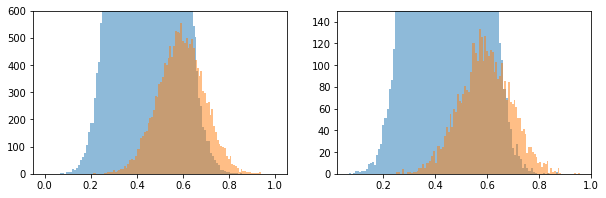

In [21]:
i = 0
trans_train_prime = trans_train[:,i]
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, trans_train_prime)
auc_train = metrics.auc(fpr_train, tpr_train)

trans_val_prime = trans_val[:,i]
fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, trans_val_prime)
auc_val = metrics.auc(fpr_val, tpr_val)
print('--------',i,'----------')
print(auc_train)
print(auc_val)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist((trans_train_prime[neg_mask_train]), bins=100, alpha=0.5)
plt.hist((trans_train_prime[pos_mask_train]), bins=100, alpha=0.5)
plt.ylim(0,600)

plt.subplot(1,2,2)
plt.hist((trans_val_prime[neg_mask_val]), bins=100, alpha=0.5)
plt.hist((trans_val_prime[pos_mask_val]), bins=100, alpha=0.5)
plt.ylim(0,150)
plt.show()

------------------
0.890172177425396
0.8883312522988172


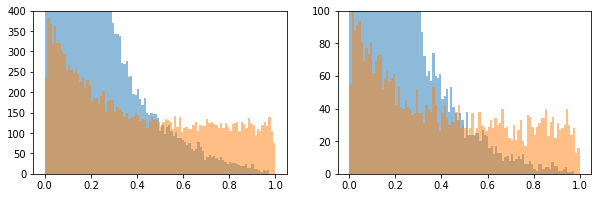

In [22]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)

y_train_pred_gnb = clf.predict_proba(X_train)[:,1]
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_pred_gnb)
auc_train = metrics.auc(fpr_train, tpr_train)

y_val_pred_gnb = clf.predict_proba(X_val)[:,1]
fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, y_val_pred_gnb)
auc_val = metrics.auc(fpr_val, tpr_val)

print('------------------')
print(auc_train)
print(auc_val)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist((y_train_pred_gnb[neg_mask_train]), bins=100, alpha=0.5)
plt.hist((y_train_pred_gnb[pos_mask_train]), bins=100, alpha=0.5)
plt.ylim(0,400)

plt.subplot(1,2,2)
plt.hist((y_val_pred_gnb[neg_mask_val]), bins=100, alpha=0.5)
plt.hist((y_val_pred_gnb[pos_mask_val]), bins=100, alpha=0.5)
plt.ylim(0,100)
plt.show()

In [7]:
df_post_train = pd.read_csv('train_posterior.csv')
post_train = df_post_train.drop('ID_code', axis=1).values
ID_train = df_post_train['ID_code'].values

df_post_val = pd.read_csv('val_posterior.csv')
post_val = df_post_val.drop('ID_code', axis=1).values
ID_val = df_post_val['ID_code'].values

In [10]:
mm_post = MinMaxScaler()

mean_post_train_dum = post_train.mean(axis=1).reshape(-1,1)
mean_post_train = mm_post.fit_transform(mean_post_train_dum)

mean_post_val_dum = post_val.mean(axis=1).reshape(-1,1)
mean_post_val = mm_post.transform(mean_post_val_dum)

------------------
0.935498310088453
0.8714307838240704


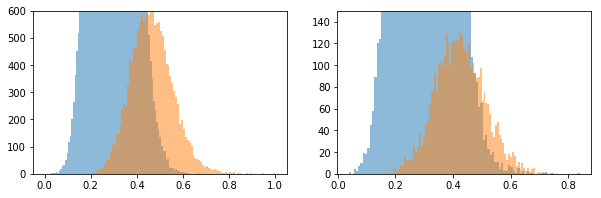

In [11]:
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, mean_post_train)
auc_train = metrics.auc(fpr_train, tpr_train)


fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, mean_post_val)
auc_val = metrics.auc(fpr_val, tpr_val)
print('------------------')
print(auc_train)
print(auc_val)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist((mean_post_train[neg_mask_train]), bins=100, alpha=0.5)
plt.hist((mean_post_train[pos_mask_train]), bins=100, alpha=0.5)
plt.ylim(0, 600)

plt.subplot(1,2,2)
plt.hist((mean_post_val[neg_mask_val]), bins=100, alpha=0.5)
plt.hist((mean_post_val[pos_mask_val]), bins=100, alpha=0.5)
plt.ylim(0, 150)
plt.show()

In [12]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'binary',
    'boost_from_average':False,
    'metric': 'auc',
    'boosting_type': 'gbdt', 
'feature_fraction': 0.9666651908960289, 'learning_rate': 0.04224333581709092, 'subsample': 0.9157208458236706, 'min_data_in_leaf': 54, 'min_sum_hessian_in_leaf': 0.00602878983483423, 'bagging_fraction': 0.8543386093311209, 'bagging_freq': 8, 'min_gain_to_split': 0.973776085975423, 'lambda_l1': 0.1900486044234061, 'lambda_l2': 0.4506713201194305, 'num_leaves': 21, 'max_bin': 163 
}
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_val,
                num_boost_round=10000,
                early_stopping_rounds=100,
                verbose_eval = 200) 

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.853275
[400]	valid_0's auc: 0.877762
[600]	valid_0's auc: 0.886184
[800]	valid_0's auc: 0.890585
[1000]	valid_0's auc: 0.892589
[1200]	valid_0's auc: 0.893187
[1400]	valid_0's auc: 0.893491
[1600]	valid_0's auc: 0.893616
Early stopping, best iteration is:
[1535]	valid_0's auc: 0.893788


In [16]:
y_train_pred_gbm = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_val_pred_gbm = gbm.predict(X_val, num_iteration=gbm.best_iteration)

------------------
0.979305403189509
0.8937880497457127


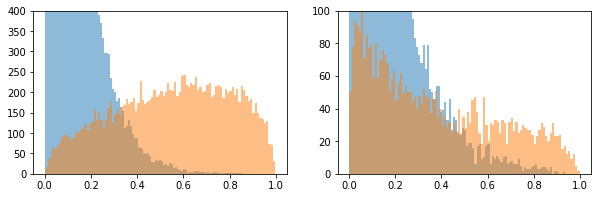

In [17]:
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_pred_gbm)
auc_train = metrics.auc(fpr_train, tpr_train)

fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, y_val_pred_gbm)
auc_val = metrics.auc(fpr_val, tpr_val)
print('------------------')
print(auc_train)
print(auc_val)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist((y_train_pred_gbm[neg_mask_train]), bins=100, alpha=0.5)
plt.hist((y_train_pred_gbm[pos_mask_train]), bins=100, alpha=0.5)
plt.ylim(0,400)

plt.subplot(1,2,2)
plt.hist((y_val_pred_gbm[neg_mask_val]), bins=100, alpha=0.5)
plt.hist((y_val_pred_gbm[pos_mask_val]), bins=100, alpha=0.5)
plt.ylim(0,100)
plt.show()

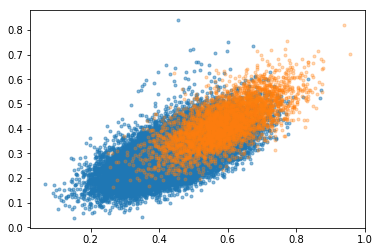

In [23]:
plt.plot(trans_val_prime[neg_mask_val], mean_post_val[neg_mask_val], ls='', marker='.', alpha=0.5)
plt.plot(trans_val_prime[pos_mask_val], mean_post_val[pos_mask_val], ls='', marker='.', alpha=0.3)
plt.show()

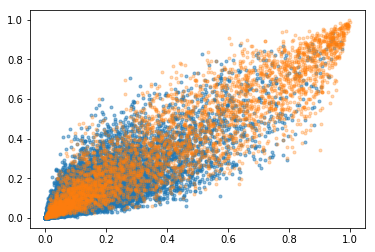

In [24]:
plt.plot(y_val_pred_gnb[neg_mask_val], y_val_pred_gbm[neg_mask_val], ls='', marker='.', alpha=0.5)
plt.plot(y_val_pred_gnb[pos_mask_val], y_val_pred_gbm[pos_mask_val], ls='', marker='.', alpha=0.3)
plt.show()

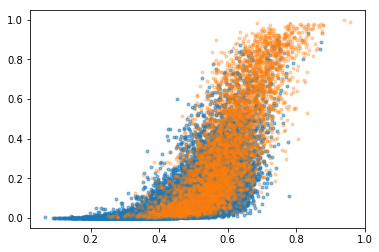

In [25]:
plt.plot(trans_val_prime[neg_mask_val], y_val_pred_gbm[neg_mask_val], ls='', marker='.', alpha=0.5)
plt.plot(trans_val_prime[pos_mask_val], y_val_pred_gbm[pos_mask_val], ls='', marker='.', alpha=0.3)
plt.show()

In [28]:
cols = [ 'prime', 'post_mean', 'GNB','lgb']
feats_train = np.array([trans_train_prime.reshape(-1), mean_post_train.reshape(-1), y_train_pred_gnb, y_train_pred_gbm]).T
feats_val = np.array([trans_val_prime.reshape(-1), mean_post_val.reshape(-1), y_val_pred_gnb, y_val_pred_gbm]).T
df_feat_val = pd.DataFrame(feats_val, columns=cols)
target_val = pd.Series(y_val, name='target')
df_feat_val = pd.concat([target_val, df_feat_val], axis=1)

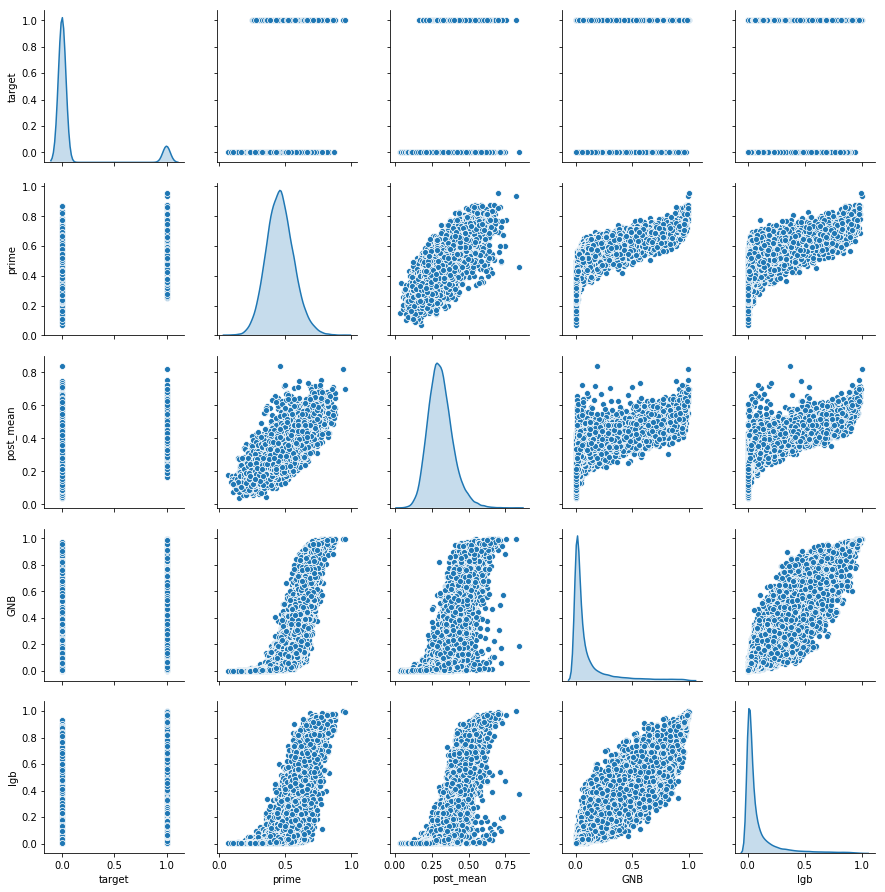

In [29]:
sns.pairplot(df_feat_val, diag_kind="kde")

<function matplotlib.pyplot.show(*args, **kw)>

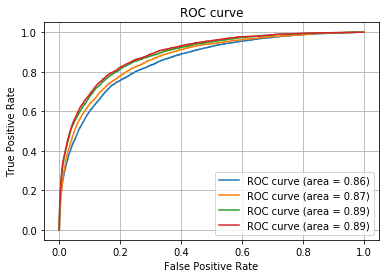

In [33]:
for feat in feats_val.T:
    fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, feat)
    auc_val = metrics.auc(fpr_val, tpr_val)

    plt.plot(fpr_val, tpr_val, label='ROC curve (area = %.2f)'%auc_val)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
#     plt.xlim(0.1,0.3)
#     plt.ylim(0.7,0.9)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

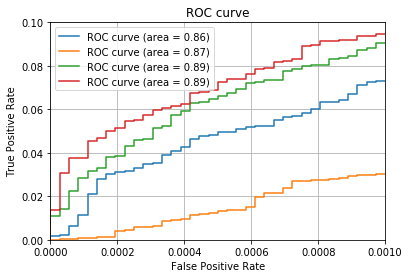

In [30]:
for feat in feats_val.T:
    fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, feat)
    auc_val = metrics.auc(fpr_val, tpr_val)

    plt.plot(fpr_val, tpr_val, label='ROC curve (area = %.2f)'%auc_val)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.xlim(0,0.001)
    plt.ylim(0,0.1)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

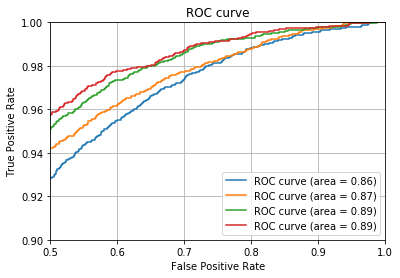

In [72]:
for feat in feats_val.T:
    fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, feat)
    auc_val = metrics.auc(fpr_val, tpr_val)

    plt.plot(fpr_val, tpr_val, label='ROC curve (area = %.2f)'%auc_val)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.xlim(0.5,1)
    plt.ylim(0.9,1)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

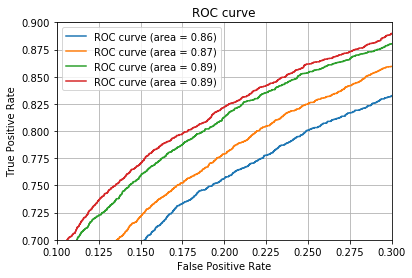

In [32]:
for feat in feats_val.T:
    fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, feat)
    auc_val = metrics.auc(fpr_val, tpr_val)

    plt.plot(fpr_val, tpr_val, label='ROC curve (area = %.2f)'%auc_val)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.xlim(0.1,0.3)
    plt.ylim(0.7,0.9)
plt.show

------------------
0.8871341734905239


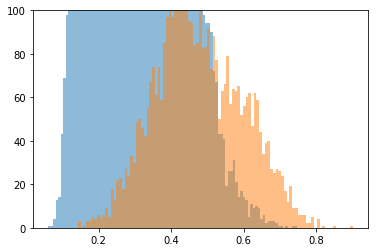

<function matplotlib.pyplot.show(*args, **kw)>

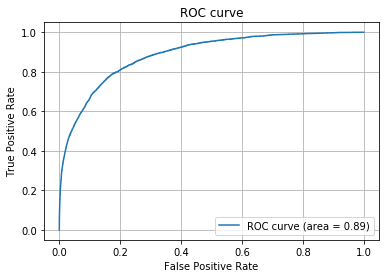

In [198]:
threshold = 0.2
com_val = np.zeros(len(y_val))


prime_upper_mask = trans_val_prime > threshold
prime_lower_mask = trans_val_prime < threshold

com_val[prime_lower_mask] = (prime_lower_mask[prime_lower_mask] * mean_post_val.reshape(-1)[prime_lower_mask]) ** 0.5
com_val[prime_upper_mask] = (trans_val_prime[prime_upper_mask]**4
                             * mean_post_val.reshape(-1)[prime_upper_mask]**4
                             * y_val_pred_gnb[prime_upper_mask]
                             * y_val_pred_gbm[prime_upper_mask]) ** (1/10)

fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, com_val)
auc_val = metrics.auc(fpr_val, tpr_val)

print('------------------')
print(auc_val)

plt.hist(com_val[neg_mask_val], bins=100, alpha=0.5)
plt.hist(com_val[pos_mask_val], bins=100, alpha=0.5)
plt.ylim(0,100)
plt.show()

plt.plot(fpr_val, tpr_val, label='ROC curve (area = %.2f)'%auc_val)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show

In [121]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [163]:
clf = GradientBoostingClassifier(criterion='mse',max_depth=3, n_estimators=50, max_leaf_nodes=5)
clf.fit(feats_train, y_train)

GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', max_depth=3, max_features=None,
              max_leaf_nodes=5, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=50, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [164]:
y_train_pred_ad = clf.predict_proba(feats_train)[:,1]
y_val_pred_ad = clf.predict_proba(feats_val)[:,1]

------------------
0.9885764132331504
0.8715051064853608


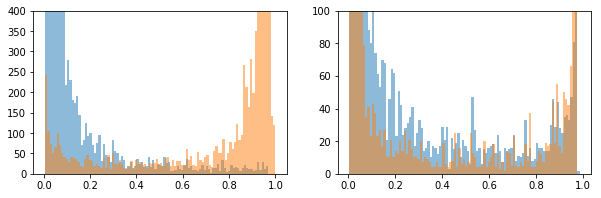

In [165]:
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_pred_ad)
auc_train = metrics.auc(fpr_train, tpr_train)

fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, y_val_pred_ad)
auc_val = metrics.auc(fpr_val, tpr_val)
print('------------------')
print(auc_train)
print(auc_val)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist((y_train_pred_ad[neg_mask_train]), bins=100, alpha=0.5)
plt.hist((y_train_pred_ad[pos_mask_train]), bins=100, alpha=0.5)
plt.ylim(0,400)

plt.subplot(1,2,2)
plt.hist((y_val_pred_ad[neg_mask_val]), bins=100, alpha=0.5)
plt.hist((y_val_pred_ad[pos_mask_val]), bins=100, alpha=0.5)
plt.ylim(0,100)
plt.show()

In [129]:
pca2 = PCA()
feats_train_pca = pca2.fit_transform(feats_train)
feats_val_pca = pca2.transform(feats_val)

------------------
0.950470287029308
0.8950361726664066


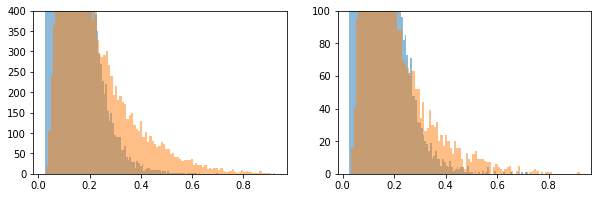

In [132]:
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, feats_train_pca[:,0])
auc_train = metrics.auc(fpr_train, tpr_train)

fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, feats_val_pca[:,0])
auc_val = metrics.auc(fpr_val, tpr_val)
print('------------------')
print(auc_train)
print(auc_val)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist((y_train_pred_ad[neg_mask_train]), bins=100, alpha=0.5)
plt.hist((y_train_pred_ad[pos_mask_train]), bins=100, alpha=0.5)
plt.ylim(0,400)

plt.subplot(1,2,2)
plt.hist((y_val_pred_ad[neg_mask_val]), bins=100, alpha=0.5)
plt.hist((y_val_pred_ad[pos_mask_val]), bins=100, alpha=0.5)
plt.ylim(0,100)
plt.show()

In [212]:
df_post_train.head()

,ID_code,post_0,post_1,post_2,post_3,post_4,post_5,post_6,post_7,post_8,...,post_190,post_191,post_192,post_193,post_194,post_195,post_196,post_197,post_198,post_199
0,train_68745,0.099844,0.107175,0.092634,0.091039,0.104705,0.090506,0.126707,0.099089,0.088760,...,0.095097,0.089860,0.109989,0.107794,0.102137,0.087231,0.104781,0.097356,0.108890,0.092366
1,train_153215,0.096592,0.084580,0.098082,0.109215,0.096981,0.092065,0.115018,0.107617,0.105174,...,0.136481,0.106936,0.107254,0.097503,0.107244,0.093960,0.092166,0.099260,0.090690,0.110068
2,train_56308,0.089744,0.088850,0.089349,0.097072,0.107922,0.094772,0.108151,0.115183,0.099542,...,0.095631,0.089860,0.106891,0.097453,0.102773,0.084581,0.081149,0.081170,0.104596,0.107407
3,train_145961,0.080121,0.109840,0.086037,0.098128,0.094497,0.089577,0.083910,0.102533,0.126514,...,0.084245,0.090090,0.085291,0.101455,0.169841,0.095573,0.097087,0.091585,0.086031,0.092890
4,train_117483,0.089460,0.099529,0.085205,0.097995,0.100650,0.094835,0.083570,0.095720,0.103234,...,0.078392,0.086931,0.102734,0.097954,0.099481,0.088652,0.099517,0.056962,0.106900,0.093089


In [ ]:
df_lr_train = pd.read_csv('train_lr_score.csv')
lr_train = df_lr_train.drop('ID_code', axis=1).values
ID_lr_train = df_lr_train['ID_code'].values

df_lr_val = pd.read_csv('val_lr_score.csv')
lr_val = df_lr_val.drop('ID_code', axis=1).values
ID_lr_val = df_lr_val['ID_code'].values

df_lr_val = pd.read_csv('val_lr_score.csv')
lr_val = df_lr_val.drop('ID_code', axis=1).values
ID_lr_val = df_lr_val['ID_code'].values

In [200]:
X_post_train = np.hstack([X_train, post_train])
X_post_val = np.hstack([X_val, post_val])

In [202]:
lgb_train = lgb.Dataset(X_post_train, y_train)
lgb_val = lgb.Dataset(X_post_val, y_val, reference=lgb_train)

In [205]:
import optuna

In [206]:
def objective(trial):
    """最小化する目的関数"""
    # LightGBM parameters
    params = {
        'objective': 'binary',
        'boost_from_average':False,
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0), # 1.0 use
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 1.0), # small for acc
        'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100), # 20 use
        'min_sum_hessian_in_leaf' : trial.suggest_uniform('min_sum_hessian_in_leaf', 1e-4, 1e-2) ,#1e-3 use
        'bagging_fraction' : trial.suggest_uniform('bagging_fraction', 0.8, 1.0) ,# 1.0 use
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10) ,# 0 use
        'min_gain_to_split': trial.suggest_uniform('min_gain_to_split', 0.8, 1.0),# 0.0 use
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0.0, 0.5),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0.0, 0.5),
        'num_leaves'   : trial.suggest_int('num_leaves', 16, 31), # 31, small for overfit, large for acc
        'max_bin': trial.suggest_int('max_bin', 128, 255), # 255, small for overfit, large for acc, 
    }
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=lgb_val,
                    num_boost_round=10000,
                    early_stopping_rounds=100,
                    verbose_eval = 200)    
    
    y_post_val_pred = gbm.predict(X_post_val, num_iteration=gbm.best_iteration)
    fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, y_post_val_pred)
    auc_val = metrics.auc(fpr_val, tpr_val)
    return  -auc_val

In [211]:
study = optuna.create_study()
study.optimize(objective, n_trials=400)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[94]	valid_0's auc: 0.844836


[I 2019-04-07 20:40:38,243] Finished trial#0 resulted in value: -0.8448355775320174. Current best value is -0.8448355775320174 with parameters: {'feature_fraction': 0.9221588048708248, 'learning_rate': 0.46308522673252506, 'subsample': 0.9581994695915046, 'min_data_in_leaf': 60, 'min_sum_hessian_in_leaf': 0.00867069607938054, 'bagging_fraction': 0.9124680930138, 'bagging_freq': 8, 'min_gain_to_split': 0.9726940192196405, 'lambda_l1': 0.3188826038496503, 'lambda_l2': 0.2724710606659448, 'num_leaves': 24, 'max_bin': 142}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	valid_0's auc: 0.824024


[I 2019-04-07 20:40:54,048] Finished trial#1 resulted in value: -0.8240236352976641. Current best value is -0.8448355775320174 with parameters: {'feature_fraction': 0.9221588048708248, 'learning_rate': 0.46308522673252506, 'subsample': 0.9581994695915046, 'min_data_in_leaf': 60, 'min_sum_hessian_in_leaf': 0.00867069607938054, 'bagging_fraction': 0.9124680930138, 'bagging_freq': 8, 'min_gain_to_split': 0.9726940192196405, 'lambda_l1': 0.3188826038496503, 'lambda_l2': 0.2724710606659448, 'num_leaves': 24, 'max_bin': 142}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's auc: 0.831489


[I 2019-04-07 20:41:06,686] Finished trial#2 resulted in value: -0.8314886103114224. Current best value is -0.8448355775320174 with parameters: {'feature_fraction': 0.9221588048708248, 'learning_rate': 0.46308522673252506, 'subsample': 0.9581994695915046, 'min_data_in_leaf': 60, 'min_sum_hessian_in_leaf': 0.00867069607938054, 'bagging_fraction': 0.9124680930138, 'bagging_freq': 8, 'min_gain_to_split': 0.9726940192196405, 'lambda_l1': 0.3188826038496503, 'lambda_l2': 0.2724710606659448, 'num_leaves': 24, 'max_bin': 142}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.844771
Early stopping, best iteration is:
[125]	valid_0's auc: 0.847891


[I 2019-04-07 20:41:28,838] Finished trial#3 resulted in value: -0.847890964853332. Current best value is -0.847890964853332 with parameters: {'feature_fraction': 0.9864735070564542, 'learning_rate': 0.4254927130917695, 'subsample': 0.8880993507493022, 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 0.0093456859055129, 'bagging_fraction': 0.9883252069812118, 'bagging_freq': 10, 'min_gain_to_split': 0.9308971982340966, 'lambda_l1': 0.055487835470327596, 'lambda_l2': 0.2785868635130333, 'num_leaves': 26, 'max_bin': 199}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[77]	valid_0's auc: 0.813146


[I 2019-04-07 20:41:43,334] Finished trial#4 resulted in value: -0.813146475792245. Current best value is -0.847890964853332 with parameters: {'feature_fraction': 0.9864735070564542, 'learning_rate': 0.4254927130917695, 'subsample': 0.8880993507493022, 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 0.0093456859055129, 'bagging_fraction': 0.9883252069812118, 'bagging_freq': 10, 'min_gain_to_split': 0.9308971982340966, 'lambda_l1': 0.055487835470327596, 'lambda_l2': 0.2785868635130333, 'num_leaves': 26, 'max_bin': 199}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.834281
Early stopping, best iteration is:
[109]	valid_0's auc: 0.836385


[I 2019-04-07 20:41:59,219] Finished trial#5 resulted in value: -0.8363845378444076. Current best value is -0.847890964853332 with parameters: {'feature_fraction': 0.9864735070564542, 'learning_rate': 0.4254927130917695, 'subsample': 0.8880993507493022, 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 0.0093456859055129, 'bagging_fraction': 0.9883252069812118, 'bagging_freq': 10, 'min_gain_to_split': 0.9308971982340966, 'lambda_l1': 0.055487835470327596, 'lambda_l2': 0.2785868635130333, 'num_leaves': 26, 'max_bin': 199}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[76]	valid_0's auc: 0.825616


[I 2019-04-07 20:42:14,118] Finished trial#6 resulted in value: -0.8256157649772262. Current best value is -0.847890964853332 with parameters: {'feature_fraction': 0.9864735070564542, 'learning_rate': 0.4254927130917695, 'subsample': 0.8880993507493022, 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 0.0093456859055129, 'bagging_fraction': 0.9883252069812118, 'bagging_freq': 10, 'min_gain_to_split': 0.9308971982340966, 'lambda_l1': 0.055487835470327596, 'lambda_l2': 0.2785868635130333, 'num_leaves': 26, 'max_bin': 199}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's auc: 0.811132


[I 2019-04-07 20:42:29,757] Finished trial#7 resulted in value: -0.8111316472114138. Current best value is -0.847890964853332 with parameters: {'feature_fraction': 0.9864735070564542, 'learning_rate': 0.4254927130917695, 'subsample': 0.8880993507493022, 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 0.0093456859055129, 'bagging_fraction': 0.9883252069812118, 'bagging_freq': 10, 'min_gain_to_split': 0.9308971982340966, 'lambda_l1': 0.055487835470327596, 'lambda_l2': 0.2785868635130333, 'num_leaves': 26, 'max_bin': 199}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[78]	valid_0's auc: 0.83052


[I 2019-04-07 20:42:49,118] Finished trial#8 resulted in value: -0.8305198299774059. Current best value is -0.847890964853332 with parameters: {'feature_fraction': 0.9864735070564542, 'learning_rate': 0.4254927130917695, 'subsample': 0.8880993507493022, 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 0.0093456859055129, 'bagging_fraction': 0.9883252069812118, 'bagging_freq': 10, 'min_gain_to_split': 0.9308971982340966, 'lambda_l1': 0.055487835470327596, 'lambda_l2': 0.2785868635130333, 'num_leaves': 26, 'max_bin': 199}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[69]	valid_0's auc: 0.831142


[I 2019-04-07 20:43:05,136] Finished trial#9 resulted in value: -0.8311420662114662. Current best value is -0.847890964853332 with parameters: {'feature_fraction': 0.9864735070564542, 'learning_rate': 0.4254927130917695, 'subsample': 0.8880993507493022, 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 0.0093456859055129, 'bagging_fraction': 0.9883252069812118, 'bagging_freq': 10, 'min_gain_to_split': 0.9308971982340966, 'lambda_l1': 0.055487835470327596, 'lambda_l2': 0.2785868635130333, 'num_leaves': 26, 'max_bin': 199}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.866912
[400]	valid_0's auc: 0.875223
Early stopping, best iteration is:
[430]	valid_0's auc: 0.875653


[I 2019-04-07 20:43:50,155] Finished trial#10 resulted in value: -0.8756531544611572. Current best value is -0.8756531544611572 with parameters: {'feature_fraction': 0.8833276062158976, 'learning_rate': 0.10500680912629146, 'subsample': 0.8580088286122662, 'min_data_in_leaf': 100, 'min_sum_hessian_in_leaf': 0.0055350118895843665, 'bagging_fraction': 0.9649942804532499, 'bagging_freq': 5, 'min_gain_to_split': 0.8011336655614488, 'lambda_l1': 0.09684592716558889, 'lambda_l2': 0.38516907541066747, 'num_leaves': 16, 'max_bin': 232}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.86304
[400]	valid_0's auc: 0.874482
[600]	valid_0's auc: 0.876298
Early stopping, best iteration is:
[688]	valid_0's auc: 0.876911


[I 2019-04-07 20:44:53,781] Finished trial#11 resulted in value: -0.8769105901841544. Current best value is -0.8769105901841544 with parameters: {'feature_fraction': 0.8769468932595564, 'learning_rate': 0.0785629131082152, 'subsample': 0.8417854784438511, 'min_data_in_leaf': 100, 'min_sum_hessian_in_leaf': 0.0015534597916850718, 'bagging_fraction': 0.9516873139255483, 'bagging_freq': 4, 'min_gain_to_split': 0.8038087300515517, 'lambda_l1': 0.4830367598617902, 'lambda_l2': 0.3866138130178498, 'num_leaves': 16, 'max_bin': 234}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.8617
Early stopping, best iteration is:
[241]	valid_0's auc: 0.862395


[I 2019-04-07 20:45:21,328] Finished trial#12 resulted in value: -0.8623950494885217. Current best value is -0.8769105901841544 with parameters: {'feature_fraction': 0.8769468932595564, 'learning_rate': 0.0785629131082152, 'subsample': 0.8417854784438511, 'min_data_in_leaf': 100, 'min_sum_hessian_in_leaf': 0.0015534597916850718, 'bagging_fraction': 0.9516873139255483, 'bagging_freq': 4, 'min_gain_to_split': 0.8038087300515517, 'lambda_l1': 0.4830367598617902, 'lambda_l2': 0.3866138130178498, 'num_leaves': 16, 'max_bin': 234}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.749021
[400]	valid_0's auc: 0.791711
[600]	valid_0's auc: 0.818607
[800]	valid_0's auc: 0.835062
[1000]	valid_0's auc: 0.845192
[1200]	valid_0's auc: 0.852783
[1400]	valid_0's auc: 0.858381
[1600]	valid_0's auc: 0.862948
[1800]	valid_0's auc: 0.866319
[2000]	valid_0's auc: 0.86898
[2200]	valid_0's auc: 0.871161
[2400]	valid_0's auc: 0.872782
[2600]	valid_0's auc: 0.874222
[2800]	valid_0's auc: 0.875437
[3000]	valid_0's auc: 0.87642
[3200]	valid_0's auc: 0.877206
[3400]	valid_0's auc: 0.877938
[3600]	valid_0's auc: 0.878441
[3800]	valid_0's auc: 0.87887
[4000]	valid_0's auc: 0.879337
[4200]	valid_0's auc: 0.879695
[4400]	valid_0's auc: 0.879951
[4600]	valid_0's auc: 0.88018
[4800]	valid_0's auc: 0.880385
[5000]	valid_0's auc: 0.8805
[5200]	valid_0's auc: 0.880622
[5400]	valid_0's auc: 0.880704
[5600]	valid_0's auc: 0.880723
Early stopping, best iteration is:
[5564]	valid_0's auc: 0.880744


[I 2019-04-07 20:54:58,920] Finished trial#13 resulted in value: -0.8807437174881567. Current best value is -0.8807437174881567 with parameters: {'feature_fraction': 0.9179780983961627, 'learning_rate': 0.007708650422772023, 'subsample': 0.8355432468612126, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0016027781551392895, 'bagging_fraction': 0.8610421456449942, 'bagging_freq': 0, 'min_gain_to_split': 0.8205889856579088, 'lambda_l1': 0.41497733295224204, 'lambda_l2': 0.4861427830171394, 'num_leaves': 19, 'max_bin': 130}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.829744
[400]	valid_0's auc: 0.858735
[600]	valid_0's auc: 0.869638
[800]	valid_0's auc: 0.87434
[1000]	valid_0's auc: 0.876735
[1200]	valid_0's auc: 0.877948
[1400]	valid_0's auc: 0.878602
[1600]	valid_0's auc: 0.878681
Early stopping, best iteration is:
[1555]	valid_0's auc: 0.878858


[I 2019-04-07 20:57:45,833] Finished trial#14 resulted in value: -0.8788580513220446. Current best value is -0.8807437174881567 with parameters: {'feature_fraction': 0.9179780983961627, 'learning_rate': 0.007708650422772023, 'subsample': 0.8355432468612126, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0016027781551392895, 'bagging_fraction': 0.8610421456449942, 'bagging_freq': 0, 'min_gain_to_split': 0.8205889856579088, 'lambda_l1': 0.41497733295224204, 'lambda_l2': 0.4861427830171394, 'num_leaves': 19, 'max_bin': 130}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.864796
Early stopping, best iteration is:
[221]	valid_0's auc: 0.866034


[I 2019-04-07 20:59:08,155] Finished trial#15 resulted in value: -0.8660336242633414. Current best value is -0.8807437174881567 with parameters: {'feature_fraction': 0.9179780983961627, 'learning_rate': 0.007708650422772023, 'subsample': 0.8355432468612126, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0016027781551392895, 'bagging_fraction': 0.8610421456449942, 'bagging_freq': 0, 'min_gain_to_split': 0.8205889856579088, 'lambda_l1': 0.41497733295224204, 'lambda_l2': 0.4861427830171394, 'num_leaves': 19, 'max_bin': 130}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.867305
Early stopping, best iteration is:
[201]	valid_0's auc: 0.867323


[I 2019-04-07 20:59:36,324] Finished trial#16 resulted in value: -0.8673225382260459. Current best value is -0.8807437174881567 with parameters: {'feature_fraction': 0.9179780983961627, 'learning_rate': 0.007708650422772023, 'subsample': 0.8355432468612126, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0016027781551392895, 'bagging_fraction': 0.8610421456449942, 'bagging_freq': 0, 'min_gain_to_split': 0.8205889856579088, 'lambda_l1': 0.41497733295224204, 'lambda_l2': 0.4861427830171394, 'num_leaves': 19, 'max_bin': 130}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.796188
[400]	valid_0's auc: 0.838139
[600]	valid_0's auc: 0.855714
[800]	valid_0's auc: 0.865105
[1000]	valid_0's auc: 0.870514
[1200]	valid_0's auc: 0.873889
[1400]	valid_0's auc: 0.87624
[1600]	valid_0's auc: 0.87767
[1800]	valid_0's auc: 0.878874
[2000]	valid_0's auc: 0.879626
[2200]	valid_0's auc: 0.880025
[2400]	valid_0's auc: 0.880336
[2600]	valid_0's auc: 0.880465
Early stopping, best iteration is:
[2664]	valid_0's auc: 0.880531


[I 2019-04-07 21:04:02,770] Finished trial#17 resulted in value: -0.8805306914565583. Current best value is -0.8807437174881567 with parameters: {'feature_fraction': 0.9179780983961627, 'learning_rate': 0.007708650422772023, 'subsample': 0.8355432468612126, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0016027781551392895, 'bagging_fraction': 0.8610421456449942, 'bagging_freq': 0, 'min_gain_to_split': 0.8205889856579088, 'lambda_l1': 0.41497733295224204, 'lambda_l2': 0.4861427830171394, 'num_leaves': 19, 'max_bin': 130}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.86381
Early stopping, best iteration is:
[226]	valid_0's auc: 0.863905


[I 2019-04-07 21:04:28,726] Finished trial#18 resulted in value: -0.8639050370714522. Current best value is -0.8807437174881567 with parameters: {'feature_fraction': 0.9179780983961627, 'learning_rate': 0.007708650422772023, 'subsample': 0.8355432468612126, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0016027781551392895, 'bagging_fraction': 0.8610421456449942, 'bagging_freq': 0, 'min_gain_to_split': 0.8205889856579088, 'lambda_l1': 0.41497733295224204, 'lambda_l2': 0.4861427830171394, 'num_leaves': 19, 'max_bin': 130}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.718196
[400]	valid_0's auc: 0.73768
[600]	valid_0's auc: 0.757105
[800]	valid_0's auc: 0.772928
[1000]	valid_0's auc: 0.786667
[1200]	valid_0's auc: 0.798266
[1400]	valid_0's auc: 0.808284
[1600]	valid_0's auc: 0.816809
[1800]	valid_0's auc: 0.824414
[2000]	valid_0's auc: 0.830585
[2200]	valid_0's auc: 0.835785
[2400]	valid_0's auc: 0.840539
[2600]	valid_0's auc: 0.844431
[2800]	valid_0's auc: 0.847678
[3000]	valid_0's auc: 0.850485
[3200]	valid_0's auc: 0.853107
[3400]	valid_0's auc: 0.855471
[3600]	valid_0's auc: 0.857492
[3800]	valid_0's auc: 0.859394
[4000]	valid_0's auc: 0.861163
[4200]	valid_0's auc: 0.862672
[4400]	valid_0's auc: 0.864127
[4600]	valid_0's auc: 0.865295
[4800]	valid_0's auc: 0.866477
[5000]	valid_0's auc: 0.867559
[5200]	valid_0's auc: 0.868686
[5400]	valid_0's auc: 0.869812
[5600]	valid_0's auc: 0.87074
[5800]	valid_0's auc: 0.871512
[6000]	valid_0's auc: 0.872356
[6200]	valid_

[I 2019-04-07 21:21:06,522] Finished trial#19 resulted in value: -0.880093978412551. Current best value is -0.8807437174881567 with parameters: {'feature_fraction': 0.9179780983961627, 'learning_rate': 0.007708650422772023, 'subsample': 0.8355432468612126, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0016027781551392895, 'bagging_fraction': 0.8610421456449942, 'bagging_freq': 0, 'min_gain_to_split': 0.8205889856579088, 'lambda_l1': 0.41497733295224204, 'lambda_l2': 0.4861427830171394, 'num_leaves': 19, 'max_bin': 130}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.858463
Early stopping, best iteration is:
[161]	valid_0's auc: 0.859155


[I 2019-04-07 21:21:26,142] Finished trial#20 resulted in value: -0.8591553004847912. Current best value is -0.8807437174881567 with parameters: {'feature_fraction': 0.9179780983961627, 'learning_rate': 0.007708650422772023, 'subsample': 0.8355432468612126, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0016027781551392895, 'bagging_fraction': 0.8610421456449942, 'bagging_freq': 0, 'min_gain_to_split': 0.8205889856579088, 'lambda_l1': 0.41497733295224204, 'lambda_l2': 0.4861427830171394, 'num_leaves': 19, 'max_bin': 130}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[98]	valid_0's auc: 0.835137


[I 2019-04-07 21:21:39,967] Finished trial#21 resulted in value: -0.8351374934665196. Current best value is -0.8807437174881567 with parameters: {'feature_fraction': 0.9179780983961627, 'learning_rate': 0.007708650422772023, 'subsample': 0.8355432468612126, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0016027781551392895, 'bagging_fraction': 0.8610421456449942, 'bagging_freq': 0, 'min_gain_to_split': 0.8205889856579088, 'lambda_l1': 0.41497733295224204, 'lambda_l2': 0.4861427830171394, 'num_leaves': 19, 'max_bin': 130}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.867764
[400]	valid_0's auc: 0.868694
Early stopping, best iteration is:
[334]	valid_0's auc: 0.869877


[I 2019-04-07 21:22:15,717] Finished trial#22 resulted in value: -0.8698768525355436. Current best value is -0.8807437174881567 with parameters: {'feature_fraction': 0.9179780983961627, 'learning_rate': 0.007708650422772023, 'subsample': 0.8355432468612126, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0016027781551392895, 'bagging_fraction': 0.8610421456449942, 'bagging_freq': 0, 'min_gain_to_split': 0.8205889856579088, 'lambda_l1': 0.41497733295224204, 'lambda_l2': 0.4861427830171394, 'num_leaves': 19, 'max_bin': 130}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[94]	valid_0's auc: 0.846682


[I 2019-04-07 21:22:31,744] Finished trial#23 resulted in value: -0.8466822018313105. Current best value is -0.8807437174881567 with parameters: {'feature_fraction': 0.9179780983961627, 'learning_rate': 0.007708650422772023, 'subsample': 0.8355432468612126, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0016027781551392895, 'bagging_fraction': 0.8610421456449942, 'bagging_freq': 0, 'min_gain_to_split': 0.8205889856579088, 'lambda_l1': 0.41497733295224204, 'lambda_l2': 0.4861427830171394, 'num_leaves': 19, 'max_bin': 130}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.869044
[400]	valid_0's auc: 0.872387
Early stopping, best iteration is:
[417]	valid_0's auc: 0.872499


[I 2019-04-07 21:23:10,871] Finished trial#24 resulted in value: -0.8724985135467742. Current best value is -0.8807437174881567 with parameters: {'feature_fraction': 0.9179780983961627, 'learning_rate': 0.007708650422772023, 'subsample': 0.8355432468612126, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0016027781551392895, 'bagging_fraction': 0.8610421456449942, 'bagging_freq': 0, 'min_gain_to_split': 0.8205889856579088, 'lambda_l1': 0.41497733295224204, 'lambda_l2': 0.4861427830171394, 'num_leaves': 19, 'max_bin': 130}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.853863
Early stopping, best iteration is:
[157]	valid_0's auc: 0.855193


[I 2019-04-07 21:23:29,806] Finished trial#25 resulted in value: -0.8551934463314333. Current best value is -0.8807437174881567 with parameters: {'feature_fraction': 0.9179780983961627, 'learning_rate': 0.007708650422772023, 'subsample': 0.8355432468612126, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0016027781551392895, 'bagging_fraction': 0.8610421456449942, 'bagging_freq': 0, 'min_gain_to_split': 0.8205889856579088, 'lambda_l1': 0.41497733295224204, 'lambda_l2': 0.4861427830171394, 'num_leaves': 19, 'max_bin': 130}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.807854
[400]	valid_0's auc: 0.847344
[600]	valid_0's auc: 0.86264
[800]	valid_0's auc: 0.870199
[1000]	valid_0's auc: 0.874737
[1200]	valid_0's auc: 0.877617
[1400]	valid_0's auc: 0.879414
[1600]	valid_0's auc: 0.880469
[1800]	valid_0's auc: 0.881203
[2000]	valid_0's auc: 0.881325
[2200]	valid_0's auc: 0.881484
Early stopping, best iteration is:
[2181]	valid_0's auc: 0.881509


[I 2019-04-07 21:27:03,420] Finished trial#26 resulted in value: -0.88150876385167. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.840406
Early stopping, best iteration is:
[108]	valid_0's auc: 0.844681


[I 2019-04-07 21:27:19,921] Finished trial#27 resulted in value: -0.8446805577449052. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[97]	valid_0's auc: 0.84868


[I 2019-04-07 21:27:36,740] Finished trial#28 resulted in value: -0.8486798428646096. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.811701
Early stopping, best iteration is:
[100]	valid_0's auc: 0.818639


[I 2019-04-07 21:27:53,207] Finished trial#29 resulted in value: -0.8186393836819239. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[89]	valid_0's auc: 0.838854


[I 2019-04-07 21:28:08,917] Finished trial#30 resulted in value: -0.8388543732145277. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.867623
Early stopping, best iteration is:
[266]	valid_0's auc: 0.868649


[I 2019-04-07 21:28:39,146] Finished trial#31 resulted in value: -0.8686488347589457. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.850542
Early stopping, best iteration is:
[136]	valid_0's auc: 0.853741


[I 2019-04-07 21:28:59,218] Finished trial#32 resulted in value: -0.8537407597919242. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.863554
[400]	valid_0's auc: 0.875602
[600]	valid_0's auc: 0.876691
Early stopping, best iteration is:
[587]	valid_0's auc: 0.876894


[I 2019-04-07 21:30:10,912] Finished trial#33 resulted in value: -0.876894066355272. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.843915
Early stopping, best iteration is:
[126]	valid_0's auc: 0.848469


[I 2019-04-07 21:30:29,369] Finished trial#34 resulted in value: -0.8484693265191552. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[84]	valid_0's auc: 0.832127


[I 2019-04-07 21:30:41,836] Finished trial#35 resulted in value: -0.8321272044447026. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[78]	valid_0's auc: 0.832325


[I 2019-04-07 21:30:57,272] Finished trial#36 resulted in value: -0.8323250893946057. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.857696
Early stopping, best iteration is:
[181]	valid_0's auc: 0.858252


[I 2019-04-07 21:31:19,055] Finished trial#37 resulted in value: -0.85825195866139. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's auc: 0.820418


[I 2019-04-07 21:31:32,015] Finished trial#38 resulted in value: -0.8204175135993187. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.867778
Early stopping, best iteration is:
[265]	valid_0's auc: 0.868344


[I 2019-04-07 21:32:03,685] Finished trial#39 resulted in value: -0.8683438007295373. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.848464
Early stopping, best iteration is:
[117]	valid_0's auc: 0.852521


[I 2019-04-07 21:32:23,407] Finished trial#40 resulted in value: -0.8525213150478844. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.841066
Early stopping, best iteration is:
[105]	valid_0's auc: 0.844164


[I 2019-04-07 21:32:42,679] Finished trial#41 resulted in value: -0.8441640878431632. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.868727
[400]	valid_0's auc: 0.876436
[600]	valid_0's auc: 0.876276
Early stopping, best iteration is:
[531]	valid_0's auc: 0.876899


[I 2019-04-07 21:33:28,702] Finished trial#42 resulted in value: -0.8768994728967724. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.861656
Early stopping, best iteration is:
[160]	valid_0's auc: 0.862342


[I 2019-04-07 21:33:49,020] Finished trial#43 resulted in value: -0.8623417100157909. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.854024
[400]	valid_0's auc: 0.871601
[600]	valid_0's auc: 0.876711
[800]	valid_0's auc: 0.877986
Early stopping, best iteration is:
[891]	valid_0's auc: 0.878215


[I 2019-04-07 21:35:44,749] Finished trial#44 resulted in value: -0.8782149356054636. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[89]	valid_0's auc: 0.840981


[I 2019-04-07 21:36:00,411] Finished trial#45 resulted in value: -0.8409813218510007. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.846971
Early stopping, best iteration is:
[134]	valid_0's auc: 0.849706


[I 2019-04-07 21:36:17,891] Finished trial#46 resulted in value: -0.8497055992964582. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[79]	valid_0's auc: 0.823705


[I 2019-04-07 21:36:31,586] Finished trial#47 resulted in value: -0.8237046078667253. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.863117
Early stopping, best iteration is:
[277]	valid_0's auc: 0.864183


[I 2019-04-07 21:37:01,658] Finished trial#48 resulted in value: -0.8641829416010554. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[95]	valid_0's auc: 0.825916


[I 2019-04-07 21:37:17,495] Finished trial#49 resulted in value: -0.8259158625991776. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.853654
Early stopping, best iteration is:
[137]	valid_0's auc: 0.854446


[I 2019-04-07 21:37:41,600] Finished trial#50 resulted in value: -0.8544461613555348. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.869874
Early stopping, best iteration is:
[258]	valid_0's auc: 0.871063


[I 2019-04-07 21:38:28,426] Finished trial#51 resulted in value: -0.8710633809828014. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.871157
[400]	valid_0's auc: 0.876426
Early stopping, best iteration is:
[393]	valid_0's auc: 0.876531


[I 2019-04-07 21:39:09,013] Finished trial#52 resulted in value: -0.8765305490335981. Current best value is -0.88150876385167 with parameters: {'feature_fraction': 0.9149320496400882, 'learning_rate': 0.017948609137065436, 'subsample': 0.8059149353244562, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001096530739897933, 'bagging_fraction': 0.8708748614236586, 'bagging_freq': 3, 'min_gain_to_split': 0.8229420142741031, 'lambda_l1': 0.35751553513063433, 'lambda_l2': 0.41413148476425266, 'num_leaves': 22, 'max_bin': 187}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.739229
[400]	valid_0's auc: 0.774
[600]	valid_0's auc: 0.798912
[800]	valid_0's auc: 0.817789
[1000]	valid_0's auc: 0.831682
[1200]	valid_0's auc: 0.841355
[1400]	valid_0's auc: 0.848656
[1600]	valid_0's auc: 0.854026
[1800]	valid_0's auc: 0.858568
[2000]	valid_0's auc: 0.862235
[2200]	valid_0's auc: 0.865402
[2400]	valid_0's auc: 0.867888
[2600]	valid_0's auc: 0.870009
[2800]	valid_0's auc: 0.871775
[3000]	valid_0's auc: 0.873337
[3200]	valid_0's auc: 0.874641
[3400]	valid_0's auc: 0.875733
[3600]	valid_0's auc: 0.876656
[3800]	valid_0's auc: 0.877594
[4000]	valid_0's auc: 0.878224
[4200]	valid_0's auc: 0.878869
[4400]	valid_0's auc: 0.879464
[4600]	valid_0's auc: 0.879838
[4800]	valid_0's auc: 0.880166
[5000]	valid_0's auc: 0.880572
[5200]	valid_0's auc: 0.880884
[5400]	valid_0's auc: 0.881099
[5600]	valid_0's auc: 0.881402
[5800]	valid_0's auc: 0.881556
[6000]	valid_0's auc: 0.881781
[6200]	valid_0

[I 2019-04-07 21:52:54,736] Finished trial#53 resulted in value: -0.882263978882685. Current best value is -0.882263978882685 with parameters: {'feature_fraction': 0.8433512746865707, 'learning_rate': 0.005208284912346234, 'subsample': 0.8598784948190974, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.001980494771669364, 'bagging_fraction': 0.9444353480110119, 'bagging_freq': 6, 'min_gain_to_split': 0.8236909222054914, 'lambda_l1': 0.07543990276439708, 'lambda_l2': 0.3460595853867902, 'num_leaves': 24, 'max_bin': 195}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[96]	valid_0's auc: 0.839734


[I 2019-04-07 21:56:10,415] Finished trial#54 resulted in value: -0.8397336552368784. Current best value is -0.882263978882685 with parameters: {'feature_fraction': 0.8433512746865707, 'learning_rate': 0.005208284912346234, 'subsample': 0.8598784948190974, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.001980494771669364, 'bagging_fraction': 0.9444353480110119, 'bagging_freq': 6, 'min_gain_to_split': 0.8236909222054914, 'lambda_l1': 0.07543990276439708, 'lambda_l2': 0.3460595853867902, 'num_leaves': 24, 'max_bin': 195}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[77]	valid_0's auc: 0.834514


[I 2019-04-07 21:56:24,848] Finished trial#55 resulted in value: -0.8345144898077705. Current best value is -0.882263978882685 with parameters: {'feature_fraction': 0.8433512746865707, 'learning_rate': 0.005208284912346234, 'subsample': 0.8598784948190974, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.001980494771669364, 'bagging_fraction': 0.9444353480110119, 'bagging_freq': 6, 'min_gain_to_split': 0.8236909222054914, 'lambda_l1': 0.07543990276439708, 'lambda_l2': 0.3460595853867902, 'num_leaves': 24, 'max_bin': 195}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.862823
[400]	valid_0's auc: 0.875796
[600]	valid_0's auc: 0.878105
Early stopping, best iteration is:
[612]	valid_0's auc: 0.87832


[I 2019-04-07 21:57:52,521] Finished trial#56 resulted in value: -0.8783202041487946. Current best value is -0.882263978882685 with parameters: {'feature_fraction': 0.8433512746865707, 'learning_rate': 0.005208284912346234, 'subsample': 0.8598784948190974, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.001980494771669364, 'bagging_fraction': 0.9444353480110119, 'bagging_freq': 6, 'min_gain_to_split': 0.8236909222054914, 'lambda_l1': 0.07543990276439708, 'lambda_l2': 0.3460595853867902, 'num_leaves': 24, 'max_bin': 195}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.838351
Early stopping, best iteration is:
[115]	valid_0's auc: 0.842938


[I 2019-04-07 21:58:11,958] Finished trial#57 resulted in value: -0.8429384483917266. Current best value is -0.882263978882685 with parameters: {'feature_fraction': 0.8433512746865707, 'learning_rate': 0.005208284912346234, 'subsample': 0.8598784948190974, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.001980494771669364, 'bagging_fraction': 0.9444353480110119, 'bagging_freq': 6, 'min_gain_to_split': 0.8236909222054914, 'lambda_l1': 0.07543990276439708, 'lambda_l2': 0.3460595853867902, 'num_leaves': 24, 'max_bin': 195}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[69]	valid_0's auc: 0.822027


[I 2019-04-07 21:58:29,094] Finished trial#58 resulted in value: -0.8220271557720016. Current best value is -0.882263978882685 with parameters: {'feature_fraction': 0.8433512746865707, 'learning_rate': 0.005208284912346234, 'subsample': 0.8598784948190974, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.001980494771669364, 'bagging_fraction': 0.9444353480110119, 'bagging_freq': 6, 'min_gain_to_split': 0.8236909222054914, 'lambda_l1': 0.07543990276439708, 'lambda_l2': 0.3460595853867902, 'num_leaves': 24, 'max_bin': 195}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.85015
Early stopping, best iteration is:
[146]	valid_0's auc: 0.85299


[I 2019-04-07 21:58:53,995] Finished trial#59 resulted in value: -0.8529899902931147. Current best value is -0.882263978882685 with parameters: {'feature_fraction': 0.8433512746865707, 'learning_rate': 0.005208284912346234, 'subsample': 0.8598784948190974, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.001980494771669364, 'bagging_fraction': 0.9444353480110119, 'bagging_freq': 6, 'min_gain_to_split': 0.8236909222054914, 'lambda_l1': 0.07543990276439708, 'lambda_l2': 0.3460595853867902, 'num_leaves': 24, 'max_bin': 195}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.858002
Early stopping, best iteration is:
[178]	valid_0's auc: 0.859052


[I 2019-04-07 21:59:21,397] Finished trial#60 resulted in value: -0.8590524517490368. Current best value is -0.882263978882685 with parameters: {'feature_fraction': 0.8433512746865707, 'learning_rate': 0.005208284912346234, 'subsample': 0.8598784948190974, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.001980494771669364, 'bagging_fraction': 0.9444353480110119, 'bagging_freq': 6, 'min_gain_to_split': 0.8236909222054914, 'lambda_l1': 0.07543990276439708, 'lambda_l2': 0.3460595853867902, 'num_leaves': 24, 'max_bin': 195}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.858504
Early stopping, best iteration is:
[170]	valid_0's auc: 0.859868


[I 2019-04-07 21:59:51,579] Finished trial#61 resulted in value: -0.8598678577650933. Current best value is -0.882263978882685 with parameters: {'feature_fraction': 0.8433512746865707, 'learning_rate': 0.005208284912346234, 'subsample': 0.8598784948190974, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.001980494771669364, 'bagging_fraction': 0.9444353480110119, 'bagging_freq': 6, 'min_gain_to_split': 0.8236909222054914, 'lambda_l1': 0.07543990276439708, 'lambda_l2': 0.3460595853867902, 'num_leaves': 24, 'max_bin': 195}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.707625
[400]	valid_0's auc: 0.719804
[600]	valid_0's auc: 0.729465
[800]	valid_0's auc: 0.73615
[1000]	valid_0's auc: 0.744333
[1200]	valid_0's auc: 0.753007
[1400]	valid_0's auc: 0.76135
[1600]	valid_0's auc: 0.7691
[1800]	valid_0's auc: 0.775881
[2000]	valid_0's auc: 0.78242
[2200]	valid_0's auc: 0.788746
[2400]	valid_0's auc: 0.794242
[2600]	valid_0's auc: 0.799198
[2800]	valid_0's auc: 0.804046
[3000]	valid_0's auc: 0.808763
[3200]	valid_0's auc: 0.812988
[3400]	valid_0's auc: 0.817186
[3600]	valid_0's auc: 0.820855
[3800]	valid_0's auc: 0.824205
[4000]	valid_0's auc: 0.827304
[4200]	valid_0's auc: 0.830053
[4400]	valid_0's auc: 0.832634
[4600]	valid_0's auc: 0.834968
[4800]	valid_0's auc: 0.83709
[5000]	valid_0's auc: 0.839102
[5200]	valid_0's auc: 0.841006
[5400]	valid_0's auc: 0.842731
[5600]	valid_0's auc: 0.844363
[5800]	valid_0's auc: 0.845838
[6000]	valid_0's auc: 0.847346
[6200]	valid_0's 

[I 2019-04-07 22:37:32,051] Finished trial#62 resulted in value: -0.8658369423034908. Current best value is -0.882263978882685 with parameters: {'feature_fraction': 0.8433512746865707, 'learning_rate': 0.005208284912346234, 'subsample': 0.8598784948190974, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.001980494771669364, 'bagging_fraction': 0.9444353480110119, 'bagging_freq': 6, 'min_gain_to_split': 0.8236909222054914, 'lambda_l1': 0.07543990276439708, 'lambda_l2': 0.3460595853867902, 'num_leaves': 24, 'max_bin': 195}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.864571
Early stopping, best iteration is:
[246]	valid_0's auc: 0.865431


[I 2019-04-07 22:38:07,680] Finished trial#63 resulted in value: -0.8654310437805415. Current best value is -0.882263978882685 with parameters: {'feature_fraction': 0.8433512746865707, 'learning_rate': 0.005208284912346234, 'subsample': 0.8598784948190974, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.001980494771669364, 'bagging_fraction': 0.9444353480110119, 'bagging_freq': 6, 'min_gain_to_split': 0.8236909222054914, 'lambda_l1': 0.07543990276439708, 'lambda_l2': 0.3460595853867902, 'num_leaves': 24, 'max_bin': 195}.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[85]	valid_0's auc: 0.838777


[I 2019-04-07 22:38:22,065] Finished trial#64 resulted in value: -0.8387766489951576. Current best value is -0.882263978882685 with parameters: {'feature_fraction': 0.8433512746865707, 'learning_rate': 0.005208284912346234, 'subsample': 0.8598784948190974, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.001980494771669364, 'bagging_fraction': 0.9444353480110119, 'bagging_freq': 6, 'min_gain_to_split': 0.8236909222054914, 'lambda_l1': 0.07543990276439708, 'lambda_l2': 0.3460595853867902, 'num_leaves': 24, 'max_bin': 195}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.86533
[400]	valid_0's auc: 0.874261
[600]	valid_0's auc: 0.876627
Early stopping, best iteration is:
[599]	valid_0's auc: 0.876679


[I 2019-04-07 22:39:23,528] Finished trial#65 resulted in value: -0.8766793118896901. Current best value is -0.882263978882685 with parameters: {'feature_fraction': 0.8433512746865707, 'learning_rate': 0.005208284912346234, 'subsample': 0.8598784948190974, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.001980494771669364, 'bagging_fraction': 0.9444353480110119, 'bagging_freq': 6, 'min_gain_to_split': 0.8236909222054914, 'lambda_l1': 0.07543990276439708, 'lambda_l2': 0.3460595853867902, 'num_leaves': 24, 'max_bin': 195}.


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.712623
[400]	valid_0's auc: 0.726549
[600]	valid_0's auc: 0.741818
[800]	valid_0's auc: 0.756708
[1000]	valid_0's auc: 0.769648
[1200]	valid_0's auc: 0.781441
[1400]	valid_0's auc: 0.790791
[1600]	valid_0's auc: 0.799257
[1800]	valid_0's auc: 0.806911
[2000]	valid_0's auc: 0.813651
[2200]	valid_0's auc: 0.820127
[2400]	valid_0's auc: 0.825474
[2600]	valid_0's auc: 0.830539
[2800]	valid_0's auc: 0.834889
[3000]	valid_0's auc: 0.838416
[3200]	valid_0's auc: 0.841452
[3400]	valid_0's auc: 0.844195
[3600]	valid_0's auc: 0.84689
[3800]	valid_0's auc: 0.849314
[4000]	valid_0's auc: 0.851447
[4200]	valid_0's auc: 0.853431
[4400]	valid_0's auc: 0.855372
[4600]	valid_0's auc: 0.857153
[4800]	valid_0's auc: 0.858692
[5000]	valid_0's auc: 0.860082
[5200]	valid_0's auc: 0.861338
[5400]	valid_0's auc: 0.862526
[5600]	valid_0's auc: 0.863701
[5800]	valid_0's auc: 0.864853
[6000]	valid_0's auc: 0.865729
[6200]	valid

KeyboardInterrupt: 

In [ ]:
params = {
    'objective': 'binary',
    'boost_from_average':False,
    'metric': 'auc',
    'boosting_type': 'gbdt', 
    'feature_fraction': study.best_params['feature_fraction'], # 1.0 use
    'learning_rate': study.best_params['learning_rate'], # small for acc
    'subsample': study.best_params['subsample'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'], # 20 use
    'min_sum_hessian_in_leaf' : study.best_params['min_sum_hessian_in_leaf'] ,#1e-3 use
    'bagging_fraction' :  study.best_params['bagging_fraction'],# 1.0 use
    'bagging_freq': study.best_params['bagging_freq'],#, 0 use
    'min_gain_to_split': study.best_params['min_gain_to_split'],# 0.0 use
    'lambda_l1': study.best_params['lambda_l1'],
    'lambda_l2': study.best_params['lambda_l2'],
    'num_leaves': study.best_params['num_leaves'], # 31, small for overfit, large for acc
    'max_bin': study.best_params['max_bin'], # 255, small for overfit, large for acc, 
}

In [ ]:
# params = {
#     'objective': 'binary',
#     'boost_from_average':False,
#     'metric': 'auc',
#     'boosting_type': 'gbdt', 
# 'feature_fraction': 0.9666651908960289, 'learning_rate': 0.04224333581709092, 'subsample': 0.9157208458236706, 'min_data_in_leaf': 54, 'min_sum_hessian_in_leaf': 0.00602878983483423, 'bagging_fraction': 0.8543386093311209, 'bagging_freq': 8, 'min_gain_to_split': 0.973776085975423, 'lambda_l1': 0.1900486044234061, 'lambda_l2': 0.4506713201194305, 'num_leaves': 21, 'max_bin': 163 
# }

In [ ]:
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_val,
                num_boost_round=10000,
                early_stopping_rounds=100,
                verbose_eval = 200) 

In [ ]:
y_post_train_pred_gbm = gbm.predict(X_post_train, num_iteration=gbm.best_iteration)
y_post_val_pred_gbm = gbm.predict(X_post_val, num_iteration=gbm.best_iteration)

In [ ]:
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_post_train_pred_gbm)
auc_train = metrics.auc(fpr_train, tpr_train)

fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, y_post_val_pred_gbm)
auc_val = metrics.auc(fpr_val, tpr_val)
print('------------------')
print(auc_train)
print(auc_val)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist((y_train_pred_gbm[neg_mask_train]), bins=100, alpha=0.5)
plt.hist((y_train_pred_gbm[pos_mask_train]), bins=100, alpha=0.5)
plt.ylim(0,400)

plt.subplot(1,2,2)
plt.hist((y_val_pred_gbm[neg_mask_val]), bins=100, alpha=0.5)
plt.hist((y_val_pred_gbm[pos_mask_val]), bins=100, alpha=0.5)
plt.ylim(0,100)
plt.show()